# Imports

In [1]:
from scipy.stats import norm as normal
import math
import numpy as np

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
%matplotlib notebook

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import MaxNLocator

# Implementations Formulas

## Price Formulas

In [5]:
def calcDs(S, K, r, sigma, t):
    d1 = (math.log(S/K) + (r + sigma**2/2)*t)/(sigma * math.sqrt(t))
    d2 = d1 - sigma * math.sqrt(t)
    return (d1,d2)

In [6]:
def calcCall(S,K,t,r,sigma):
    (d1,d2) = calcDs(S, K, r, sigma, t)
    return round(S*normal.cdf(d1) - K *math.exp(-r*t)*normal.cdf(d2),2)

def calcPut(S,K,t,r,sigma):
    (d1,d2) = calcDs(S, K, r, sigma, t)
    return round(K*math.exp(-r*t)*normal.cdf(-d2) - S * normal.cdf(-d1),2)

In [7]:
def calcOption(optionType, S, K, t, r):
    if optionType == "Put":
        return calcPut(S, K, t, r, sigma)
    if optionType == "Call":
        return calcCall(S, K, t, r, sigma)        

## Greeks

In [8]:
def calcDeltaCall(S,K, t,r, sigma):
    d1 = calcDs(S, K, r, sigma, t)[0]
    return normal.cdf(d1)

In [9]:
def calcThetaCall(S,K, t,r, sigma):
    (d1,d2) = calcDs(S, K, r, sigma, t)
    term1 = S*phi(d1,0,1)*sigma/(2*math.sqrt(t))
    term2 = r*K*math.exp(-1*r*t)*normal.cdf(d2)
    return -1*term1 - term2

In [10]:
def calcGammaCall(S,K, t,r, sigma):
    d1 = calcDs(S, K, r, sigma, t)[0]
    return phi(d1, 0,1)/(S*sigma*math.sqrt(t))

In [11]:
def calcVegaCall(S,K, t,r, sigma):
    d1 = calcDs(S, K, r, sigma, t)[0]
    term1 = S*phi(d1,0,1)
    term2 = math.sqrt(t)
    return term1 *term2

In [12]:
def calcRhoCall(S,K, t,r, sigma):
    (d1,d2) = calcDs(S, K, r, sigma, t)
    term1 = t*K*math.exp(-1*r*t)
    term2 = normal.cdf(d2)
    return term1*term2

# Utils

In [13]:
def phi(x,mu, sigma):
    return 1/math.sqrt(2*math.pi * sigma**2 )*math.exp(-(x-mu)**2/(2*(sigma**2)))
    

# Implementation Interactions

# Visualization

<IPython.core.display.Javascript object>


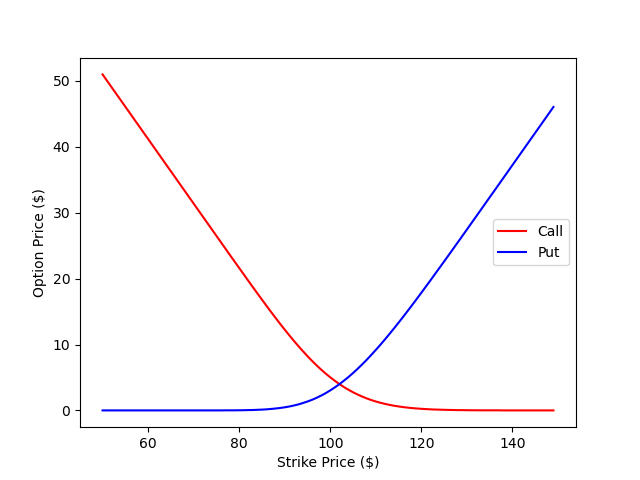

In [14]:
Strikes = np.arange(50, 150)
vals_call = [calcCall(100,K, 1 , 0.02, 0.10) for K in Strikes]
vals_put = [calcPut(100,K, 1 , 0.02, 0.10) for K in Strikes]
plt.plot(Strikes,vals_call, 'r', label = "Call")
plt.plot(Strikes, vals_put, 'b', label  = "Put")
plt.legend()
plt.ylabel("Option Price ($)")
plt.xlabel("Strike Price ($)")
plt.show()

In [15]:
def plotPricePutCallByStrike(S,t,r,sigma):
    fig = plt.figure()
    Strikes = np.arange(50, 150)
    vals_call = [calcCall(S,K, t , r, sigma) for K in Strikes]
    vals_put = [calcPut(S,K, t , r, sigma) for K in Strikes]
    plt.plot(Strikes,vals_call, 'r', label = "Call")
    plt.plot(Strikes, vals_put, 'b', label  = "Put")
    plt.legend()
    plt.ylabel("Option Price ($)")
    plt.xlabel("Strike Price ($)")
    plt.show()

In [16]:
interactive_plot1 = interactive(plotPricePutCallByStrike,
                               S = 100,
                               t = 1,
                               r = 0.02,
                               sigma= 0.1)
interactive_plot1

interactive(children=(IntSlider(value=100, description='S', max=300, min=-100), IntSlider(value=1, description…

In [17]:
def plotCallPriceSKfixed(t1,r1,sigma1, t2, r2, sigma2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(90, 110, 1)
    X, Y = np.meshgrid(x, y)
    
    vectorizedPartialSK1 = np.vectorize(lambda S,K: calcCall(S,K,t1,r1,sigma1))
    vectorizedPartialSK2 = np.vectorize(lambda S,K: calcCall(S,K,t2,r2,sigma2))
    
    zs1 = np.array(vectorizedPartialSK1(np.ravel(X), np.ravel(Y)))
    Z1 = zs1.reshape(X.shape)
    
    zs2 = np.array(vectorizedPartialSK2(np.ravel(X), np.ravel(Y)))
    Z2 = zs2.reshape(X.shape)
    
    
    
    
    ax.scatter(X, Y, Z1)
    ax.scatter(X, Y, Z2)

    xa = ax.get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True))
    ya = ax.get_yaxis()
    ya.set_major_locator(MaxNLocator(integer=True))


    ax.set_xlabel('Asset Price')
    ax.set_ylabel('Strike Price')
    ax.set_zlabel('BS-Call-Price')

In [18]:
interactive_plot2 = interactive(plotCallPriceSKfixed,
                               t1 = 1.1,
                               r1 = widgets.FloatSlider(min= 0, max=0.50, step=0.01, value=0.01),
                               sigma1 = widgets.FloatSlider(min= 0.001, max=0.9, step=0.01, value=0.05),
                               t2 = 1.5,
                               r2 = widgets.FloatSlider(min= 0, max=0.50, step=0.01, value=0.05),
                               sigma2 = widgets.FloatSlider(min= 0.001, max=0.9, step=0.01, value=0.15))


interactive_plot2

interactive(children=(FloatSlider(value=1.1, description='t1', max=3.3000000000000003, min=-1.1), FloatSlider(…

In [19]:
def plotCallPriceSigmaTfixed(S1,K1,r1, S2, K2, r2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(0.01, 1, 0.05)
    X, Y = np.meshgrid(x, y)
    
    vectorizedPartialSigmaT1 = np.vectorize(lambda sigma, t: calcCall(S1,K1,t,r1,sigma))
    zs1 = np.array(vectorizedPartialSigmaT1(np.ravel(X), np.ravel(Y)))
    Z1 = zs1.reshape(X.shape)
    
    vectorizedPartialSigmaT2 = np.vectorize(lambda sigma, t: calcCall(S2,K2,t,r2,sigma))
    zs2 = np.array(vectorizedPartialSigmaT2(np.ravel(X), np.ravel(Y)))
    Z2 = zs2.reshape(X.shape)

    ax.scatter(X, Y, Z1)
    ax.scatter(X,Y, Z2)

    xa = ax.get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True))
    ya = ax.get_yaxis()
    ya.set_major_locator(MaxNLocator(integer=True))


    ax.set_xlabel('Vola')
    ax.set_ylabel('timeToMaturity')
    ax.set_zlabel('BS-Call-Price')

interactive_plot3 = interactive(plotCallPriceSigmaTfixed,
                               S1 = 100,
                               K1 = 110,
                               r1 = 0.01,
                               S2 = 110,
                               K2 = 115,
                               r2 = 0.05)
                               

interactive_plot3

interactive(children=(IntSlider(value=100, description='S1', max=300, min=-100), IntSlider(value=110, descript…

In [20]:
def plotDeltaStockPriceExpiry(K,r,sigma):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(90, 120, 0.5)
    y = np.arange(0.01, 2, 0.05)
    X, Y = np.meshgrid(x, y)
    
    vectorizedPartialDelta1 = np.vectorize(lambda S, t: calcDeltaCall(S,K, t,r, sigma))
    zs1 = np.array(vectorizedPartialDelta1(np.ravel(X), np.ravel(Y)))
    Z1 = zs1.reshape(X.shape)
    
    ax.scatter(X, Y, Z1)

    xa = ax.get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True))
    ya = ax.get_yaxis()
    ya.set_major_locator(MaxNLocator(integer=True))


    ax.set_xlabel('Asset Price')
    ax.set_ylabel('timeToMaturity')
    ax.set_zlabel('Call Delta')
    

In [21]:
interactive_plot4 = interactive(plotDeltaStockPriceExpiry,
                               K = 110,
                               r = widgets.FloatSlider(min= 0, max=0.50, step=0.01, value=0.01),
                               sigma = widgets.FloatSlider(min= 0.001, max=0.9, step=0.01, value=0.05))
                               

interactive_plot4

interactive(children=(IntSlider(value=110, description='K', max=330, min=-110), FloatSlider(value=0.01, descri…

In [22]:
def plotGammaStockPriceExpiry(K,r,sigma):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(105, 115, 0.5)
    y = np.arange(0.01, 1, 0.02)
    X, Y = np.meshgrid(x, y)
    
    vectorizedPartialGamma1 = np.vectorize(lambda S, t: calcGammaCall(S,K, t,r, sigma))
    zs1 = np.array(vectorizedPartialGamma1(np.ravel(X), np.ravel(Y)))
    Z1 = zs1.reshape(X.shape)
    
    ax.scatter(X, Y, Z1)

    xa = ax.get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True))
    ya = ax.get_yaxis()
    ya.set_major_locator(MaxNLocator(integer=True))


    ax.set_xlabel('Asset Price')
    ax.set_ylabel('timeToMaturity')
    ax.set_zlabel('Call Gamma')

In [23]:
interactive_plot5 = interactive(plotGammaStockPriceExpiry,
                               K = 110,
                               r = widgets.FloatSlider(min= 0, max=0.50, step=0.01, value=0.01),
                               sigma = widgets.FloatSlider(min= 0.001, max=0.9, step=0.01, value=0.10))
                               

interactive_plot5

interactive(children=(IntSlider(value=110, description='K', max=330, min=-110), FloatSlider(value=0.01, descri…

In [32]:
def plotVegaStockPriceExpiry(K,r,sigma):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(80, 120, 1)
    y = np.arange(0.01, 2, 0.05)
    X, Y = np.meshgrid(x, y)
    
    vectorizedPartialVega1 = np.vectorize(lambda S, t: calcVegaCall(S,K, t,r, sigma))
    zs1 = np.array(vectorizedPartialVega1(np.ravel(X), np.ravel(Y)))
    Z1 = zs1.reshape(X.shape)
    
    ax.scatter(X, Y, Z1)

    xa = ax.get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True))
    ya = ax.get_yaxis()
    ya.set_major_locator(MaxNLocator(integer=True))


    ax.set_xlabel('Asset Price')
    ax.set_ylabel('timeToMaturity')
    ax.set_zlabel('Call Vega')

In [33]:
interactive_plot6 = interactive(plotVegaStockPriceExpiry,
                               K = 110,
                               r = widgets.FloatSlider(min= 0, max=0.50, step=0.01, value=0.01),
                               sigma = widgets.FloatSlider(min= 0.001, max=0.9, step=0.01, value=0.10))
                               

interactive_plot6

interactive(children=(IntSlider(value=110, description='K', max=330, min=-110), FloatSlider(value=0.01, descri…

In [56]:
def plotThetaStockPriceExpiry(K,r,sigma):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(105, 115, 0.1)
    y = np.arange(0.01, 0.3, 0.01)
    X, Y = np.meshgrid(x, y)
    
    vectorizedPartialTheta1 = np.vectorize(lambda S, t: calcThetaCall(S,K, t,r, sigma))
    zs1 = np.array(vectorizedPartialTheta1(np.ravel(X), np.ravel(Y)))
    Z1 = zs1.reshape(X.shape)
    
    ax.scatter(X, Y, Z1)

    xa = ax.get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True))
    ya = ax.get_yaxis()
    ya.set_major_locator(MaxNLocator(integer=True))


    ax.set_xlabel('Asset Price')
    ax.set_ylabel('timeToMaturity')
    ax.set_zlabel('Call Theta')

In [57]:
interactive_plot7 = interactive(plotThetaStockPriceExpiry,
                               K = 110,
                               r = widgets.FloatSlider(min= 0, max=0.50, step=0.01, value=0.01),
                               sigma = widgets.FloatSlider(min= 0.001, max=0.9, step=0.01, value=0.10))
                               

interactive_plot7

interactive(children=(IntSlider(value=110, description='K', max=330, min=-110), FloatSlider(value=0.01, descri…

In [67]:
def plotRhoStockPriceExpiry(K,r,sigma):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(90, 150, 1)
    y = np.arange(0.01, 2, 0.05)
    X, Y = np.meshgrid(x, y)
    
    vectorizedPartialRho1 = np.vectorize(lambda S, t: calcRhoCall(S,K, t,r, sigma))
    zs1 = np.array(vectorizedPartialRho1(np.ravel(X), np.ravel(Y)))
    Z1 = zs1.reshape(X.shape)
    
    ax.scatter(X, Y, Z1)

    xa = ax.get_xaxis()
    xa.set_major_locator(MaxNLocator(integer=True))
    ya = ax.get_yaxis()
    ya.set_major_locator(MaxNLocator(integer=True))


    ax.set_xlabel('Asset Price')
    ax.set_ylabel('timeToMaturity')
    ax.set_zlabel('Call Rho')

In [68]:
interactive_plot8 = interactive(plotRhoStockPriceExpiry,
                               K = 110,
                               r = widgets.FloatSlider(min= 0, max=0.50, step=0.01, value=0.01),
                               sigma = widgets.FloatSlider(min= 0.001, max=0.9, step=0.01, value=0.10))
                               

interactive_plot8

interactive(children=(IntSlider(value=110, description='K', max=330, min=-110), FloatSlider(value=0.01, descri…

# Tests

In [24]:
print(phi(x = 0,mu = 0 , sigma = 1)*math.sqrt(2*math.pi))

1.0


In [25]:
S = 100
K = 110
t = 1
r = 0.02
sigma = 0.10
print("Optionspreis:" + str(calcCall(S,K, t,r, sigma)))
print("Delta: " + str(calcDeltaCall(S,K, t,r, sigma)))
print("Gamma: " + str(calcGammaCall(S,K, t,r, sigma)))
print("Vega: " + str(calcVegaCall(S,K, t,r, sigma)))
print("Rho " + str(calcRhoCall(S,K, t,r, sigma)))
print("Theta: " + str(calcThetaCall(S,K, t,r, sigma)))

Optionspreis:1.35
Delta: 0.24099615585831619
Gamma: 0.031157518596646044
Vega: 31.157518596646046
Rho 22.745877220313464
Theta: -2.012793474238572


In [26]:
#test CalcDs
print(calcDs(S = 100, K = 100, r = 1, sigma = math.sqrt(2), t=1))
print(calcDs(S = 1000,K = 1, t = 1, r = 0.01, sigma = 0.05))

(1.414213562373095, -2.220446049250313e-16)
(138.38010557964273, 138.33010557964272)


In [27]:
#test calcCall
print(calcCall(S = 1000,K = 1, t = 1, r = 0.01, sigma = 0.05))
print(calcCall(S = 100,K = 110, t = 1, r = 0.01, sigma = 0.00001))

999.01
0.0


In [28]:
print(calcCall(S = 100,K = 100, t = 1, r = 0.01, sigma = 0.05))

2.52
